
# TP4 ALTEGRAD - Graph Mining - JAN 2022



# PART 1 : Analyzing a Real-World Graph

In [189]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
############## Task 1 : Load Graph and Simple Statistics

##################

G = nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/ALTEGRAD/ALTEGRAD_lab_4_graph_mining/code/datasets/CA-HepTh.txt',comments='#',delimiter='\t')

n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()
print('Number of edges : ',n_edges)
print('Number of nodes : ',n_nodes)


##################

Number of edges :  25998
Number of nodes :  9877


In [192]:

############## Task 2 : Connected Components


##################

ccompo = list(nx.connected_components(G)) #connected components
n_ccompo = nx.number_connected_components(G)
len(ccompo) == n_ccompo #sanity check
print('Number of connected components : ', n_ccompo)



Gc = G.subgraph(max(ccompo, key=len)) #subgraph of the largest connected component
len(max(ccompo, key=len)) == len(ccompo[0]) #the first component is the largest one
G.subgraph(Gc).number_of_nodes() == len(Gc) #sanity check
print('Number of nodes in the largest component : ', Gc.number_of_nodes()) #number of nodes in the largest component
print('Number of edges in the largest component : ',Gc.number_of_edges())

# Fraction of nodes and edges in Gc
print('Fraction of nodes in Gc : ', Gc.number_of_nodes() / G.number_of_nodes())
print('Fraction of edges in Gc : ', Gc.number_of_edges() / G.number_of_edges())

##################

Number of connected components :  429
Number of nodes in the largest component :  8638
Number of edges in the largest component :  24827
Fraction of nodes in Gc :  0.8745570517363572
Fraction of edges in Gc :  0.9549580736979768


In [193]:

############## Task 3 : Find and print the minimum, maximum, median and mean degree of the nodes of the graph
# Degree
degree_sequence = [G.degree(node) for node in G.nodes()] #degree sequence of the graph
print('Max degree : ',max(degree_sequence))
print('Min degree : ',min(degree_sequence))
print('Mean degree : ',np.mean(degree_sequence))
print('Median degree of nodes : ',np.median(degree_sequence))

Max degree :  65
Min degree :  1
Mean degree :  5.264351523742027
Median degree of nodes :  3.0


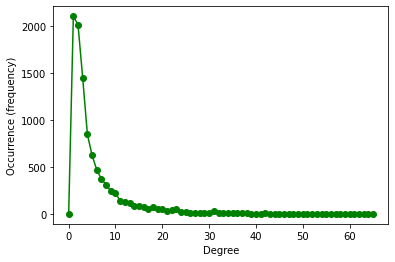

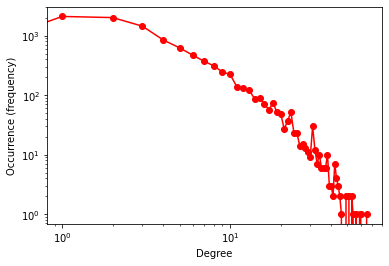

In [194]:
############## Task 4 : Plot the degree histogram

##################
dh = nx.degree_histogram(G) #list of the frequency of each degree value
# Degree distribution

plt.figure(1)
plt.plot(dh,'g',marker='o')
plt.ylabel("Occurrence (frequency)")
plt.xlabel("Degree")
plt.draw()
plt.show()

#with the loglog plt function
plt.figure(2)
plt.loglog(dh,'r',marker='o')
plt.ylabel("Occurrence (frequency)")
plt.xlabel("Degree")
plt.draw()
plt.show()

In [195]:
############## Task 5 : Calculate the global clustering coefficent

##################
G_trans = nx.transitivity(G) #graph transitivity, the fraction of all possible triangles present in G.
print(G_trans)
##################

0.2839996525875546


# PART 2 : Community Detection

In [196]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from random import randint
from sklearn import cluster
from sklearn.cluster import KMeans
from scipy.sparse import diags

In [197]:
############## Task 6
# Perform spectral clustering to partition graph G into k clusters

#IN : Graph G = (V,E) and parameter k
# OUT : cluster assignments of each node of the graph)



def spectral_clustering(G, k):
  
  A = nx.adjacency_matrix(G) #adjacency matrix of G
  Dinv = diags([1 / G.degree(node) for node in G.nodes()])
  n = G.number_of_nodes()
  Lrw = np.eye(n) - Dinv @ A
  eig_values, eig_vectors = eigs(Lrw, k=k, which='SR') # Calculate eigenvalues and eigenvectors, keeping smallest real parts
  eig_vectors = eig_vectors.real
  km = KMeans(n_clusters=k)
  km.fit(eig_vectors)
  clustering = {node: km.labels_[i] for i, node in enumerate(G.nodes())}
  return clustering

In [198]:
# Apply the Spectral Clustering algorithm to the giant connected component of the CA-HepTh dataset, trying to identify 50 clusters.


############## Task 7

##################

clustering = spectral_clustering(G=Gc, k=50)

##################

In [199]:
############## Task 8
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):

    n_edges = G.number_of_edges()
    clusters = set(clustering.values())
    modularity = 0

    for cluster in clusters:
        clust_nodes = [node for node in G.nodes() if clustering[node] == cluster]
        current_subgraph = G.subgraph(clust_nodes)
        lc = current_subgraph.number_of_edges()
        dc = sum(G.degree(node) for node in clust_nodes)
        modularity += lc/n_edges - (dc/(2*n_edges))**2
    
    return modularity


In [200]:

############## Task 9

##################

#Modularity for the giant component 
print('Modularity giant component : ', modularity(Gc, clustering))
##################

Modularity giant component :  0.16211955289024355


# PART 3 : Graph Classification using Graph Kernels


Recap : Kernels can be intuitively understood as functions measuring the similarity of pairs of objects.

In [201]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [202]:


############## Task 10 : Dataset Generation
# Generate simple dataset

# Classification : Each graph is assigned a class label: label 0 if it is a cycle or label 1 if it is a path


def create_dataset():
    Gs = list()
    y = list()

    ##################  
    for n in range(3, 103):
      Gs.append(nx.path_graph(n))
      y.append(0)
      Gs.append(nx.cycle_graph(n))
      y.append(1)
    ##################

    return Gs, y


Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(G_train), len(all_paths)))
    for i in range(len(G_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


In [203]:
############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(G_train), 4))
    

    ##################
    for i, graph in enumerate(Gs_train):
        for _ in range(n_samples):
            node_choice = np.random.choice(
                np.arange(graph.number_of_edges()), size=3)
            subgraph = graph.subgraph(node_choice)

            for j, graphlet in enumerate(graphlets):
                if nx.is_isomorphic(subgraph, graphlet):
                    phi_train[i, j] += 1
    ##################


    phi_test = np.zeros((len(G_test), 4))
    
    ##################
    for i, graph in enumerate(Gs_test):
      for _ in range(n_samples):
          node_choice = np.random.choice(
              np.arange(graph.number_of_edges()), size=3)
          subgraph = graph.subgraph(node_choice)

          for j, graphlet in enumerate(graphlets):
              if nx.is_isomorphic(subgraph, graphlet):
                  phi_test[i, j] += 1
    ##################

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)





In [204]:
############## Task 12

##################
K_train_gk, K_test_gk = graphlet_kernel(G_train, G_test)
##################


In [205]:

############## Task 13

##################
clf = SVC(kernel="precomputed")
clf.fit(K_train_sp, y_train)


y_pred = clf.predict(K_test_sp)
print('Shortest path kernel accuracy :', accuracy_score(y_test, y_pred))

# SVM + graphlet training
clf = SVC(kernel="precomputed")
clf.fit(K_train_gk, y_train)

# predict
y_pred = clf.predict(K_test_gk)

print('Graphlet kernel accuracy : ', accuracy_score(y_test, y_pred))
##################

Shortest path kernel accuracy : 1.0
Graphlet kernel accuracy :  0.3
